In [1]:
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from augerino.datasets import LocalRotMNIST
%matplotlib inline

In [2]:
dataset = LocalRotMNIST("~/datasets")

/iris/u/ayz/anaconda3/envs/augerino/lib/python3.7/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/iris/u/ayz/anaconda3/envs/augerino/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Number of targets: 55.


Text(0.5, 1.0, 'Target: 9')

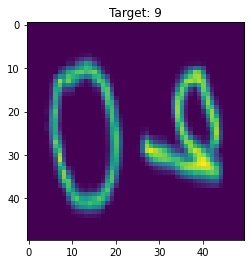

In [3]:
im, target = dataset[np.random.randint(60000)]
img = im.numpy().squeeze(0)
plt.imshow(img)
plt.title(f"Target: {target}")

In [4]:
targets = [tgt for data, tgt in dataset]

In [5]:
target_counts = {}
for val in dataset.tgts2tgt.values():
    target_counts[val] = 0
for target in targets:
    target_counts[target] += 1

In [6]:
target_counts

{0: 588,
 1: 1346,
 2: 1141,
 3: 1240,
 4: 1194,
 5: 1111,
 6: 1207,
 7: 1177,
 8: 1120,
 9: 1134,
 10: 780,
 11: 1295,
 12: 1381,
 13: 1305,
 14: 1147,
 15: 1347,
 16: 1390,
 17: 1351,
 18: 1362,
 19: 654,
 20: 1164,
 21: 1146,
 22: 1062,
 23: 1185,
 24: 1251,
 25: 1182,
 26: 1182,
 27: 630,
 28: 1184,
 29: 1090,
 30: 1214,
 31: 1261,
 32: 1214,
 33: 1254,
 34: 547,
 35: 1081,
 36: 1140,
 37: 1230,
 38: 1131,
 39: 1179,
 40: 464,
 41: 1081,
 42: 1172,
 43: 1075,
 44: 1095,
 45: 595,
 46: 1230,
 47: 1065,
 48: 1177,
 49: 700,
 50: 1212,
 51: 1207,
 52: 581,
 53: 1190,
 54: 559}